# Convolutional Neural Network

### Libraries

In [3]:
# import libraries

import os
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.models import inception_v3, resnet50

from xml.etree import ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torch import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### Data preparation

In [4]:
# major variables

photos_dir = './photos'
renders_dir = './renders'

In [5]:
def parse_xml(xml_file):
    '''
    Read the xml file and return the bounding box coordinates
    '''
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bounding_boxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bounding_boxes.append([xmin, ymin, xmax, ymax])
    return bounding_boxes

In [6]:
def load_data(data_dir):
    '''
    Returns a list of images and labels for each image
    '''
    image_paths = []
    num_legos = []
    for subdir, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.jpg'):
                n = int(subdir.split(os.sep)[-1])
                image_paths.append(os.path.join(subdir, file))
                num_legos.append(n)
    combined = list(zip(image_paths, num_legos))
    combined.sort()
    image_paths, num_legos = zip(*combined)
    image_paths = np.asarray(image_paths)
    num_legos = torch.Tensor(num_legos).to(torch.int64)
    return image_paths, num_legos

In [7]:

image_paths, num_legos = load_data(photos_dir)
print('Number of images:', len(image_paths))
print('Number of labels:', len(num_legos))
print("last 5 labels: ", num_legos[-5:])
print("last 5 image paths: ", image_paths[-5:])

Number of images: 407
Number of labels: 407
last 5 labels:  tensor([9, 9, 9, 9, 9])
last 5 image paths:  ['./photos\\9\\IMG_20201127_002529.jpg'
 './photos\\9\\IMG_20201127_003716.jpg'
 './photos\\9\\IMG_20201127_003720.jpg'
 './photos\\9\\IMG_20201127_003725.jpg'
 './photos\\9\\IMG_20201127_234032.jpg']


In [11]:

import pandas as pd

transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

df = pd.read_csv('./train_test_split.csv')


def augment_data(folder_path):
    '''
    Augment the data
    '''
    image_paths = []

    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(subdir, file))
    for image_path in image_paths:
        image = cv2.imread(image_path)
        for i in range(5):
            augmented = transformations(image)
            augmented = augmented.permute(1, 2, 0)
            augmented = (augmented.numpy() * 255).astype('uint8') 
            new_image_path = image_path+ f'_aug_{i}.jpg'
            cv2.imwrite(new_image_path, augmented)
            # remove ./
            new_image_path = new_image_path[2:]
            df.loc[len(df)] = [new_image_path, None]
            

for x in range(6, 33):
    augment_data(f'{photos_dir}/{x}/')

new_images_df = df[df['is_test'].isnull()]
new_train_df, new_test_df = train_test_split(new_images_df, test_size=0.25)

new_train_df['is_test'] = 0
new_test_df['is_test'] = 1

df = pd.concat([df[df['is_test'].notnull()], new_train_df, new_test_df])

df.to_csv('./train_test_split.csv', index=False)

df = pd.read_csv('train_test_split.csv', header=None, names=['filename', 'is_test'])

df = df.sort_values('filename')

df.to_csv('train_test_split.csv', index=False, header=False)

In [59]:
# work with defined train test split
train_test_split = np.genfromtxt('./train_test_split.csv', delimiter=',', dtype=None, encoding=None)
train_test_ids = {
    'train': [],
    'test': []
}
for index, row in enumerate(train_test_split):
    if row[1] == '1':
      train_test_ids['test'].append(index - 1)
    elif row[1] == '0':
      train_test_ids['train'].append(index - 1)

print('Train:', len(train_test_ids['train']), 'Test:', len(train_test_ids['test']))

# print lsat 5 train_test_ids
print(train_test_ids['train'][-5:])
print(train_test_ids['test'][-5:])
print(image_paths[train_test_ids['train'][-5:]])
print(image_paths[train_test_ids['test'][-5:]])




Train: 706 Test: 136
[837, 838, 839, 840, 841]
[802, 831, 832, 833, 834]
['./photos\\9\\IMG_20201127_234032.jpg_aug_0.jpg'
 './photos\\9\\IMG_20201127_234032.jpg_aug_1.jpg'
 './photos\\9\\IMG_20201127_234032.jpg_aug_2.jpg'
 './photos\\9\\IMG_20201127_234032.jpg_aug_3.jpg'
 './photos\\9\\IMG_20201127_234032.jpg_aug_4.jpg']
['./photos\\9\\IMG_20201127_001800.jpg_aug_1.jpg'
 './photos\\9\\IMG_20201127_003725.jpg_aug_0.jpg'
 './photos\\9\\IMG_20201127_003725.jpg_aug_1.jpg'
 './photos\\9\\IMG_20201127_003725.jpg_aug_2.jpg'
 './photos\\9\\IMG_20201127_003725.jpg_aug_3.jpg']


In [60]:
# validation set

indices = train_test_ids['test']
#np.random.shuffle(indices, )
print(indices)
test_size = 0.4 * len(indices)
split = int(np.floor(test_size))
train_test_ids['valid'], train_test_ids['test'] = indices[split:], indices[:split]

len(train_test_ids['train']), len(train_test_ids['valid']), len(train_test_ids['test'])

[3, 6, 17, 31, 32, 40, 43, 46, 59, 70, 99, 103, 111, 112, 113, 115, 116, 121, 126, 127, 135, 136, 157, 159, 169, 176, 179, 192, 196, 209, 216, 223, 231, 232, 233, 241, 248, 254, 255, 256, 257, 263, 266, 267, 273, 280, 281, 282, 284, 289, 298, 304, 314, 315, 324, 334, 340, 365, 370, 375, 388, 404, 414, 416, 423, 426, 430, 431, 437, 440, 446, 447, 449, 452, 459, 464, 468, 469, 470, 475, 485, 486, 544, 546, 547, 553, 554, 555, 557, 558, 570, 572, 573, 575, 587, 600, 604, 614, 615, 616, 617, 629, 639, 652, 658, 666, 669, 674, 684, 685, 690, 697, 701, 703, 719, 724, 726, 728, 730, 751, 772, 773, 775, 776, 777, 778, 784, 786, 787, 789, 792, 802, 831, 832, 833, 834]


(706, 82, 54)

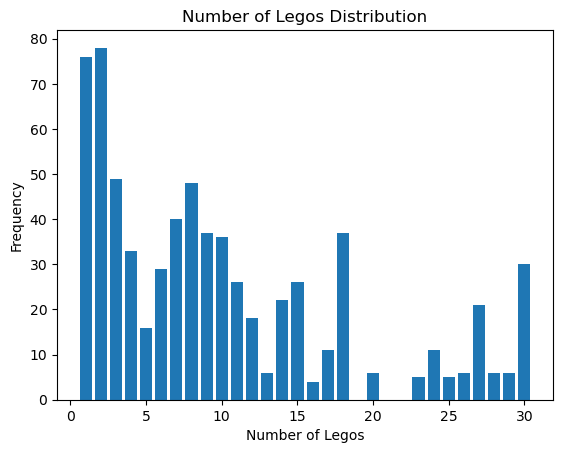

In [61]:
# class distribution in training data

num_legos_train = num_legos[train_test_ids['train']]
plt.hist(num_legos_train, bins=range(1, max(num_legos_train)), align='left', rwidth=0.8)
plt.xlabel('Number of Legos')
plt.ylabel('Frequency')
plt.title('Number of Legos Distribution')
plt.show()

In [9]:
# undersampling of larger class in training data
# indices = []
# for i in train_test_ids['train']:
#     if num_legos[i] == 1:
#         indices.append(i)
# np.random.shuffle(indices, )
# leftovers_size = 0.9 * len(indices)
# split = int(np.floor(leftovers_size))
# _, leftovers = indices[split:], indices[:split]
# for i in leftovers:
#     train_test_ids['train'].remove(i)

# num_legos_train = num_legos[train_test_ids['train']]
# plt.hist(num_legos_train, bins=range(1, max(num_legos_train)), align='left', rwidth=0.8)
# plt.xlabel('Number of Legos')
# plt.ylabel('Frequency')
# plt.title('Number of Legos Distribution')
# plt.show()

In [62]:
class LegosDataset(Dataset):
    '''
    Dataset class for the legos dataset
    '''
    def __init__(self, images_filenames, num_legos, transform=None):
        self.images_filenames = images_filenames
        self.transform = transform
        self.labels = num_legos

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        label = self.labels[idx]
        image = cv2.imread(image_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [63]:
# train, valid and test datasets

batch_size = 32
num_workers = 0

transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


train_dataset = LegosDataset(image_paths[train_test_ids['train']], num_legos[train_test_ids['train']], transform=transform)
valid_dataset = LegosDataset(image_paths[train_test_ids['valid']], num_legos[train_test_ids['valid']], transform=transform)
test_dataset = LegosDataset(image_paths[train_test_ids['test']], num_legos[train_test_ids['test']], transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

### Model definition

In [64]:
# get cpu or gpu device for training

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [13]:
# TODO: change definition

class ConvolutionalNeuralNetwork(nn.Module):
    '''
    CNN for a regression task
    '''
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [65]:
# put model in device

model = resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 1)
model = model.to(device)


print(model)

c:\Users\Henrique\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Henrique\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Model training

In [66]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    '''
    Function for one epoch iteration
    '''
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer"
    num_batches = len(dataloader)
    if is_train:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    preds = []
    labels = []
    with torch.set_grad_enabled(is_train):
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.float().to(device), y.float().to(device)
            pred = model(X).squeeze()
            if isinstance(pred, tuple):
                pred = pred[0]
            else:
                pred = pred
            loss = loss_fn(pred, y)
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item()
            preds.extend(pred.view(-1).cpu().detach().numpy())
            labels.extend(y.view(-1).cpu().numpy())
    return total_loss / num_batches, np.mean((np.array(labels) - np.array(preds))**2)

In [67]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
    '''
    Function for training the model
    '''
    train_history = {'loss': [], 'accuracy': []}
    val_history = {'loss': [], 'accuracy': []}
    best_val_loss = np.inf
    print("Start training...")

    for t in range(num_epochs):
        print(f"Epoch {t+1}/{num_epochs}")
        train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
        print(f"Train loss: {train_loss:.3f}, Train accuracy: {train_acc:.3f}")
        val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
        print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")

        # save model when val loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_dict = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': t
            }
            torch.save(save_dict, model_name + '_best_model.pth')

        # save latest model
        save_dict = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': t
        }
        torch.save(save_dict, model_name + '_latest_model.pth')

        # save training history
        train_history['loss'].append(train_loss)
        train_history['accuracy'].append(train_acc)
        val_history['loss'].append(val_loss)
        val_history['accuracy'].append(val_acc)

    print("Finished")
    return train_history, val_history

In [68]:
# loss function

loss_fn = nn.MSELoss()

In [69]:
# learning rate

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [70]:
# train model

num_epochs = 30

train_history, val_history = train(model, 'lego_counter', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...
Epoch 1/30


100%|██████████| 23/23 [02:35<00:00,  6.76s/it]


Train loss: 100.382, Train accuracy: 103.702


100%|██████████| 3/3 [00:19<00:00,  6.64s/it]


Validation loss: 63.192, Validation accuracy: 70.106
Epoch 2/30


100%|██████████| 23/23 [02:35<00:00,  6.78s/it]


Train loss: 80.230, Train accuracy: 74.030


100%|██████████| 3/3 [00:19<00:00,  6.66s/it]


Validation loss: 36.422, Validation accuracy: 41.593
Epoch 3/30


100%|██████████| 23/23 [02:35<00:00,  6.77s/it]


Train loss: 64.041, Train accuracy: 65.595


100%|██████████| 3/3 [00:20<00:00,  6.70s/it]


Validation loss: 35.149, Validation accuracy: 39.755
Epoch 4/30


100%|██████████| 23/23 [02:37<00:00,  6.86s/it]


Train loss: 55.939, Train accuracy: 58.242


100%|██████████| 3/3 [00:19<00:00,  6.64s/it]


Validation loss: 29.933, Validation accuracy: 33.795
Epoch 5/30


100%|██████████| 23/23 [02:36<00:00,  6.80s/it]


Train loss: 50.434, Train accuracy: 52.567


100%|██████████| 3/3 [00:18<00:00,  6.28s/it]


Validation loss: 34.873, Validation accuracy: 38.048
Epoch 6/30


100%|██████████| 23/23 [02:36<00:00,  6.79s/it]


Train loss: 48.162, Train accuracy: 48.044


100%|██████████| 3/3 [00:20<00:00,  6.81s/it]


Validation loss: 24.819, Validation accuracy: 27.311
Epoch 7/30


100%|██████████| 23/23 [02:38<00:00,  6.87s/it]


Train loss: 40.282, Train accuracy: 41.769


100%|██████████| 3/3 [00:20<00:00,  6.69s/it]


Validation loss: 21.503, Validation accuracy: 23.599
Epoch 8/30


100%|██████████| 23/23 [02:35<00:00,  6.75s/it]


Train loss: 36.722, Train accuracy: 37.840


100%|██████████| 3/3 [00:19<00:00,  6.57s/it]


Validation loss: 21.293, Validation accuracy: 22.883
Epoch 9/30


100%|██████████| 23/23 [02:33<00:00,  6.68s/it]


Train loss: 32.747, Train accuracy: 33.864


100%|██████████| 3/3 [00:19<00:00,  6.56s/it]


Validation loss: 18.366, Validation accuracy: 19.675
Epoch 10/30


100%|██████████| 23/23 [02:34<00:00,  6.73s/it]


Train loss: 31.328, Train accuracy: 32.299


100%|██████████| 3/3 [00:19<00:00,  6.53s/it]


Validation loss: 21.503, Validation accuracy: 22.220
Epoch 11/30


100%|██████████| 23/23 [02:26<00:00,  6.35s/it]


Train loss: 29.164, Train accuracy: 28.871


100%|██████████| 3/3 [00:18<00:00,  6.28s/it]


Validation loss: 14.292, Validation accuracy: 15.070
Epoch 12/30


100%|██████████| 23/23 [02:22<00:00,  6.19s/it]


Train loss: 28.170, Train accuracy: 27.950


100%|██████████| 3/3 [00:18<00:00,  6.06s/it]


Validation loss: 16.610, Validation accuracy: 16.985
Epoch 13/30


100%|██████████| 23/23 [02:16<00:00,  5.95s/it]


Train loss: 26.227, Train accuracy: 25.809


100%|██████████| 3/3 [00:16<00:00,  5.61s/it]


Validation loss: 18.866, Validation accuracy: 18.746
Epoch 14/30


100%|██████████| 23/23 [02:10<00:00,  5.67s/it]


Train loss: 22.816, Train accuracy: 23.579


100%|██████████| 3/3 [00:16<00:00,  5.64s/it]


Validation loss: 14.815, Validation accuracy: 14.836
Epoch 15/30


100%|██████████| 23/23 [22:03<00:00, 57.56s/it] 


Train loss: 22.031, Train accuracy: 22.560


100%|██████████| 3/3 [00:17<00:00,  5.93s/it]


Validation loss: 15.059, Validation accuracy: 14.779
Epoch 16/30


100%|██████████| 23/23 [02:34<00:00,  6.70s/it]


Train loss: 22.251, Train accuracy: 21.114


100%|██████████| 3/3 [00:19<00:00,  6.63s/it]


Validation loss: 15.631, Validation accuracy: 15.283
Epoch 17/30


100%|██████████| 23/23 [02:35<00:00,  6.77s/it]


Train loss: 22.344, Train accuracy: 21.338


100%|██████████| 3/3 [00:19<00:00,  6.65s/it]


Validation loss: 12.045, Validation accuracy: 11.973
Epoch 18/30


100%|██████████| 23/23 [02:30<00:00,  6.56s/it]


Train loss: 17.946, Train accuracy: 18.265


100%|██████████| 3/3 [00:19<00:00,  6.48s/it]


Validation loss: 10.203, Validation accuracy: 10.233
Epoch 19/30


100%|██████████| 23/23 [02:34<00:00,  6.71s/it]


Train loss: 20.571, Train accuracy: 21.303


100%|██████████| 3/3 [00:20<00:00,  6.77s/it]


Validation loss: 12.573, Validation accuracy: 12.126
Epoch 20/30


100%|██████████| 23/23 [02:36<00:00,  6.79s/it]


Train loss: 17.065, Train accuracy: 17.238


100%|██████████| 3/3 [00:20<00:00,  6.68s/it]


Validation loss: 11.869, Validation accuracy: 11.258
Epoch 21/30


100%|██████████| 23/23 [02:35<00:00,  6.78s/it]


Train loss: 17.700, Train accuracy: 16.674


100%|██████████| 3/3 [00:20<00:00,  6.68s/it]


Validation loss: 12.374, Validation accuracy: 11.733
Epoch 22/30


100%|██████████| 23/23 [02:37<00:00,  6.84s/it]


Train loss: 18.965, Train accuracy: 17.324


100%|██████████| 3/3 [00:20<00:00,  6.78s/it]


Validation loss: 11.644, Validation accuracy: 11.055
Epoch 23/30


100%|██████████| 23/23 [02:37<00:00,  6.84s/it]


Train loss: 17.461, Train accuracy: 17.128


100%|██████████| 3/3 [00:19<00:00,  6.59s/it]


Validation loss: 12.047, Validation accuracy: 11.476
Epoch 24/30


100%|██████████| 23/23 [02:36<00:00,  6.81s/it]


Train loss: 16.376, Train accuracy: 16.857


100%|██████████| 3/3 [00:19<00:00,  6.67s/it]


Validation loss: 7.970, Validation accuracy: 8.130
Epoch 25/30


100%|██████████| 23/23 [02:34<00:00,  6.72s/it]


Train loss: 15.468, Train accuracy: 14.142


100%|██████████| 3/3 [00:20<00:00,  6.92s/it]


Validation loss: 9.859, Validation accuracy: 9.474
Epoch 26/30


100%|██████████| 23/23 [02:38<00:00,  6.87s/it]


Train loss: 19.611, Train accuracy: 15.621


100%|██████████| 3/3 [00:20<00:00,  6.72s/it]


Validation loss: 8.873, Validation accuracy: 8.640
Epoch 27/30


100%|██████████| 23/23 [02:37<00:00,  6.86s/it]


Train loss: 14.576, Train accuracy: 14.965


100%|██████████| 3/3 [00:20<00:00,  6.80s/it]


Validation loss: 8.150, Validation accuracy: 7.979
Epoch 28/30


100%|██████████| 23/23 [02:38<00:00,  6.88s/it]


Train loss: 14.733, Train accuracy: 14.849


100%|██████████| 3/3 [00:20<00:00,  6.68s/it]


Validation loss: 10.533, Validation accuracy: 9.999
Epoch 29/30


100%|██████████| 23/23 [02:38<00:00,  6.88s/it]


Train loss: 17.200, Train accuracy: 15.584


100%|██████████| 3/3 [00:20<00:00,  6.79s/it]


Validation loss: 8.300, Validation accuracy: 8.149
Epoch 30/30


100%|██████████| 23/23 [02:39<00:00,  6.93s/it]


Train loss: 14.528, Train accuracy: 14.654


100%|██████████| 3/3 [00:20<00:00,  6.77s/it]

Validation loss: 10.047, Validation accuracy: 9.378
Finished


### Training evolution analysis

In [73]:
def plotTrainingHistory(train_history, val_history):
    '''
    Plot the training history of the model
    subdivision 5 to 5 
    '''
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2) 
    plt.title('MSE')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')
    y_ticks = np.arange(0, 105, step=5)

    plt.yticks(np.arange(0, 105, step=5))
    for y in y_ticks:
        plt.axhline(y, color='gray', linewidth=0.5)  # draw a horizontal line at each y-tick value


    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()
    



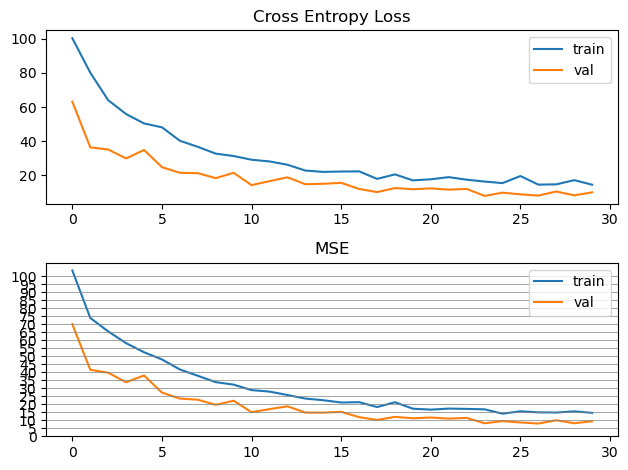

In [74]:
# visualize training history

plotTrainingHistory(train_history, val_history)

### Model testing

In [75]:
# load best model

model = resnet50(pretrained=False) 
model.fc = nn.Linear(2048, 1)

model.load_state_dict(torch.load("lego_counter_best_model.pth")['model'])



c:\Users\Henrique\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [76]:
# evaluate model on test data

test_loss, test_acc = epoch_iter(test_dataloader, model, loss_fn, is_train=False)
print(f"Test loss: {test_loss:.3f}, Test accuracy: {test_acc:.3f}")


100%|██████████| 2/2 [00:10<00:00,  5.11s/it]

Test loss: 6.893, Test accuracy: 7.236


In [93]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, num_images=32):
    '''
    Display images along with their true and predicted labels
    '''
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu().numpy())
            if len(all_images) >= num_images:
                break
    fig, axs = plt.subplots(4,8, figsize=(40, 20))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(all_images[i].transpose((1, 2, 0)))
        ax.set_title(f'True label: {all_labels[i]}, Predicted label: {int(all_preds[i].round())}')
        ax.axis('off')
    plt.tight_layout(pad=3.0)
    plt.show()

['./photos\\10\\IMG_20201127_001831.jpg_aug_2.jpg'
 './photos\\10\\IMG_20201127_002854.jpg'
 './photos\\10\\IMG_20201127_002858.jpg_aug_4.jpg'
 './photos\\10\\IMG_20201127_003844.jpg_aug_0.jpg'
 './photos\\10\\IMG_20201127_003844.jpg_aug_1.jpg'
 './photos\\10\\IMG_20201127_234039.jpg_aug_3.jpg'
 './photos\\11\\IMG_20201127_001818.jpg_aug_0.jpg'
 './photos\\11\\IMG_20201127_001818.jpg_aug_3.jpg'
 './photos\\11\\IMG_20201127_003759.jpg_aug_4.jpg'
 './photos\\11\\IMG_20201127_140935.jpg_aug_3.jpg'
 './photos\\14\\1_MFGo_original_1608916411740.jpg_aug_2.jpg'
 './photos\\14\\IMG_20201127_141315.jpg_aug_0.jpg'
 './photos\\14\\IMG_20201127_141325.jpg_aug_2.jpg'
 './photos\\14\\IMG_20201127_141325.jpg_aug_3.jpg'
 './photos\\14\\IMG_20201127_141325.jpg_aug_4.jpg'
 './photos\\14\\IMG_20201127_233719.jpg_aug_0.jpg'
 './photos\\14\\IMG_20201127_233719.jpg_aug_1.jpg'
 './photos\\14\\IMG_20201127_233812.jpg_aug_0.jpg'
 './photos\\15\\IMG_20201127_001617.jpg'
 './photos\\15\\IMG_20201127_001617.jpg_a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

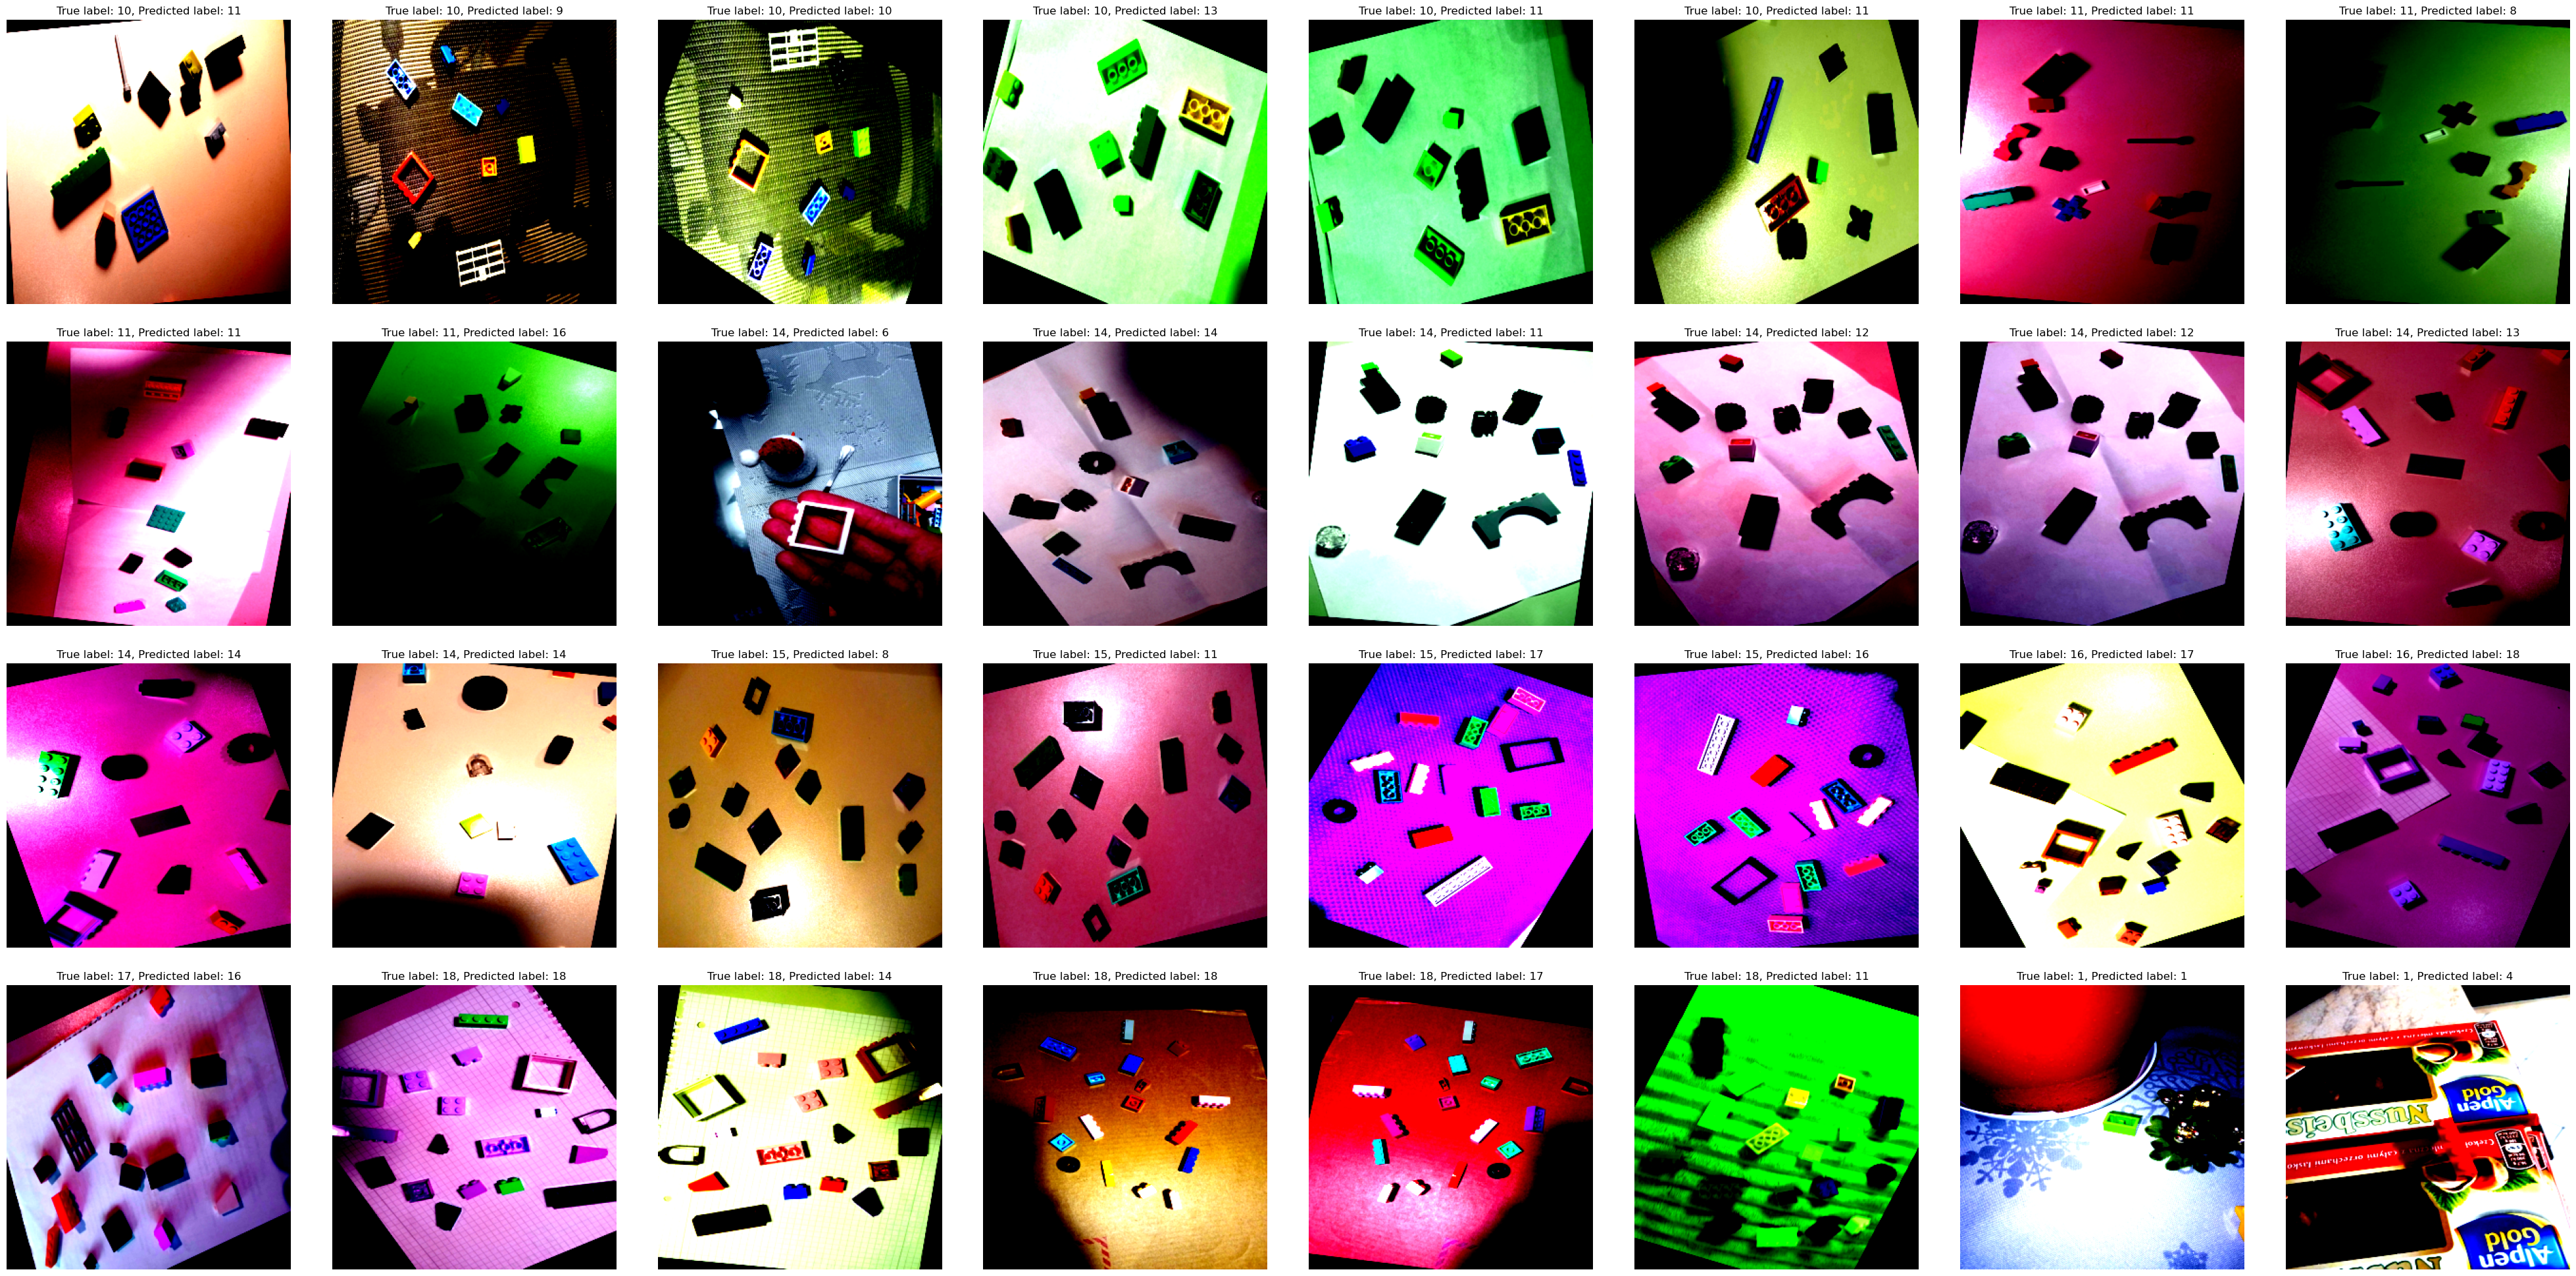

In [94]:
# view predictions
# print test_dataloader values


print(test_dataloader.batch_sampler.sampler.data_source.images_filenames[:])
show_predictions(model, test_dataloader)
